**Baran CELIK**  
ESPCI Paris – PSL  
Stage de recherche au LPSM (Laboratoire de Probabilités, Statistique et Modélisation)

# Résolution numérique d’un problème de switching optimal par apprentissage profond — Cas en dimension 2

Ce notebook prolonge le travail réalisé dans le cadre d’un stage de recherche au **LPSM (Laboratoire de Probabilités, Statistique et Modélisation)**, en tant qu’étudiant de 3ᵉ année à l’**ESPCI Paris - PSL**.

Il est consacré à l’extension en **dimension 2** de l’algorithme d’apprentissage profond pour le contrôle optimal stochastique avec switching à horizon fini, déjà testé en dimension 1.

Comme précédemment, l’approche repose sur :
- une discrétisation temporelle du système via le schéma d’Euler–Maruyama ;
- une résolution backward de l’équation de Bellman discrète ;
- deux réseaux de neurones pour approximer les espérances conditionnelles et la politique optimale.

Le but est ici d’évaluer la robustesse de la méthode neuronale dans un espace d’état bidimensionnel et de la comparer à une méthode de différences finies.

*L’analyse complète et les détails mathématiques sont présentés dans le rapport de stage associé à ce notebook.*

*Le cas unidimensionnel est traité dans un premier notebook séparé.*


In [ ]:
import gc
import math
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_sched
from torch.utils.data import DataLoader, TensorDataset
from scipy.sparse import diags, kron, eye
from scipy.sparse.linalg import spsolve

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Exemple numérique en dimension 2

Ce test permet d’évaluer l’algorithme dans un cadre plus complexe :  
l’état $x \in \mathbb{R}^2$, la dynamique dépend du régime de contrôle, et les fonctions de coût sont non linéaires.

L’objectif est de :
- apprendre la fonction valeur $v_0(x, i)$ sur une grille bidimensionnelle ;
- visualiser la politique optimale apprise ;
- comparer les résultats à une référence obtenue par différences finies.


In [ ]:
# Paramètres du problème de contrôle optimal
T = 1.0          # horizon temporel
N = 4           # nombre de pas de temps
h = T / N        # pas de discrétisation
A = [0.0, 1.0]   # ensemble des actions possibles
c = 0.05        # coût de switching
sigma = 0.1      # volatilité du bruit brownien

# Paramètres d'apprentissage
M = 1000
L = 1000
E_phi = 800      # Augmenté pour la dim supplémentaire
E_p = 800
alpha_phi = 1e-3  # Réduit légèrement
alpha_p = 1e-3
BATCH_SIZE = 256  # Augmenté
CHUNK_GPU = 2048  # Réduit

# Fonctions du problème adaptées pour 2D
def drift(x, a):
    if isinstance(x, torch.Tensor):
        # a ∈ {0,1}, pousse vers (-1, -1) ou (1,1)
        target = 2 * a - 1  # a=0 → -1, a=1 → +1
        drift_vec = target * 0.5 * torch.ones_like(x)
        return drift_vec
    else:
        target = 2 * a - 1
        return target * 0.5 * np.ones_like(x)



def diffusion(x, a):
    if isinstance(x, torch.Tensor):
        return 0.1 * torch.ones_like(x)
    else:
        return 0.1 * np.ones_like(x)



def running_cost_func(x, a):
    if isinstance(x, torch.Tensor):
        x1, x2 = x[:, 0:1], x[:, 1:2]
        center = (2 * a - 1)  # -1 ou +1
        return - ((x1 - center)**2 + (x2 - center)**2)
    else:
        x1, x2 = x[:, 0], x[:, 1]
        center = (2 * a - 1)
        return - ((x1 - center)**2 + (x2 - center)**2)



def terminal_cost_func(x):
    if isinstance(x, torch.Tensor):
        x1, x2 = x[:, 0:1], x[:, 1:2]
        return - (x1**2 + x2**2)
    else:
        x1, x2 = x[:, 0], x[:, 1]
        return - (x1**2 + x2**2)



# Fonctions adaptées pour PyTorch
@torch.no_grad()
def terminal_payoff(x):
    return terminal_cost_func(x)

@torch.no_grad()
def running_payoff(x, a):
    return running_cost_func(x, a)

@torch.no_grad()
def brownian_step(x, a, dt):
    """Step brownien pour x = [x1, x2]"""
    b = drift(x, a)
    sig = diffusion(x, a)
    dW = torch.randn_like(x) * math.sqrt(dt)
    return x + b * dt + sig * dW

### Réseaux de neurones utilisés

Les réseaux sont identiques à ceux utilisés en dimension 1, mais adaptés à une entrée bidimensionnelle $ x = (x_1, x_2) $ :

- `ExpectationNetwork` approxime l’espérance conditionnelle :
  $
  \phi(x, a) \approx \mathbb{E}[v_{k+1}(X_{k+1}, a) \mid X_k = x]
  $
- `PolicyNetwork` approxime une politique déterministe (logits),
- `PolicyNetwork2` approxime une politique stochastique (softmax).

Ils sont entraînés par régression ou classification à chaque pas de temps.


In [ ]:
class ExpectationNetwork(nn.Module):
    def __init__(self, state_dim: int = 2):
        super().__init__()
        input_dim = state_dim + 1
        hidden_dim = 256  # Augmenté pour la dimension supplémentaire

        self.network = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.ReLU(),

            nn.Linear(hidden_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.ReLU(),

            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),

            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),

            nn.Linear(hidden_dim, 1)
        )

    def forward(self, x: torch.Tensor, action: torch.Tensor) -> torch.Tensor:
        inputs = torch.cat([x, action], dim=1)
        return self.network(inputs)

class PolicyNetwork(nn.Module):
    def __init__(self, state_dim=2, hidden_dim=128):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, 2)
        )

    def forward(self, x):
        return self.model(x)

###  Fonctions d’évaluation de la fonction valeur estimée et Génération des données d’entraînement

- `compute_value()` : applique une politique déterministe et calcule le gain.
- `compute_value2()` : moyenne sur des actions échantillonnées (politique stochastique).

Ces fonctions permettent de visualiser $v_0(x, i)$ et $\pi(x).

La fonction `generate_training_data()` simule des trajectoires pour approximer, par Monte Carlo, l’espérance du gain futur pour chaque action.  
Elle retourne des triplets $(x, a, y)$ pour entraîner $\phi et $\pi.


In [ ]:
@torch.no_grad()
def compute_value(phi, policy_net, x, prev_regime=0):
    logits = policy_net(x)
    best_action = torch.argmax(logits, dim=1, keepdim=True).float()

    immediate = running_payoff(x, best_action) * h
    switch_cost = c * (best_action != prev_regime)
    fut = phi(x, best_action)

    return immediate + fut - switch_cost

@torch.no_grad()
def compute_value2(phi, policy_net, x, prev_regime=0, n_samples=20):
    probs = policy_net(x)
    total_value = 0

    for _ in range(n_samples):
        actions = torch.multinomial(probs, num_samples=1).float()

        immediate = running_payoff(x, actions) * h
        switch_cost = c * (actions != prev_regime)
        fut = phi(x, actions)

        total_value += immediate + fut - switch_cost

    return total_value / n_samples

# Génération des données d'entraînement (pour 2D)
@torch.no_grad()
def generate_training_data(k, M, L, value_fn=None, show_target=False):
    # Génération de states 2D : x = [x1, x2]
    x_cpu = 10 * torch.rand(M, 2) - 5  # (M, 2) au lieu de (M, 1)

    out = []
    for act in A:
        a_cpu = torch.full((M, 1), act)
        acc = torch.zeros(M, 1)
        acc += running_payoff(x_cpu, a_cpu) * h

        for _ in range(L):
            x_next = brownian_step(x_cpu, a_cpu, h)
            if k == N - 1:
                v = terminal_payoff(x_next)
            else:
                parts = []
                for s in range(0, M, CHUNK_GPU):
                    xi = x_next[s : s + CHUNK_GPU].to(device)
                    v0 = value_fn(xi, torch.zeros(xi.shape[0], 1, device=device))
                    v1 = value_fn(xi, torch.ones(xi.shape[0], 1, device=device))
                    parts.append(torch.max(v0, v1).cpu())
                v = torch.cat(parts, dim=0)
            acc += v
        target = acc / L

        for i in range(M):
            out.append((x_cpu[i:i+1], a_cpu[i:i+1], target[i:i+1]))

    return out

### Entraînement des réseaux de neurones (dimension 2)

Cette section contient les fonctions permettant d'entraîner les réseaux neuronaux nécessaires à la résolution backward de l’équation de Bellman discrète :

- `train_expectation()` entraîne le réseau $\phi$ par régression sur les espérances conditionnelles ;
- `train_policy_classifier()` entraîne la politique déterministe $\pi$ en utilisant une classification supervisée (CrossEntropy) ;
- `solve_neural_networks()` orchestre l’apprentissage backward sur tout l’horizon temporel.

Dans ce notebook, les réseaux ont une entrée bidimensionnelle $x \in \mathbb{R}^2$, ce qui implique une généralisation directe des architectures définies en dimension 1.


In [ ]:
def train_expectation(phi, data, epochs):
    opt = optim.Adam(phi.parameters(), lr=alpha_phi, weight_decay=5e-5)
    scheduler = lr_sched.CosineAnnealingLR(opt, T_max=epochs)
    criterion = nn.MSELoss()
    x, a, y = map(torch.vstack, zip(*data))
    loader = DataLoader(
        TensorDataset(x, a, y),
        batch_size=BATCH_SIZE,
        shuffle=True,
        pin_memory=(device.type == "cuda"),
    )
    losses = []
    for e in range(epochs):
        tot = 0.0
        for xb, ab, yb in loader:
            xb, ab, yb = xb.to(device), ab.to(device), yb.to(device)
            loss = criterion(phi(xb, ab), yb)
            opt.zero_grad()
            loss.backward()
            opt.step()
        scheduler.step()
        tot += loss.item()
        losses.append(tot / len(loader))
        if e % 50 == 0 or e == epochs - 1:
            print(f"    Epoch {e}, Φ-loss={losses[-1]:.4e}, lr={opt.param_groups[0]['lr']:.2e}")
    return losses

def train_policy_classifier(policy_net, phi, x_states, epochs, prev_regime=0):
    opt = optim.Adam(policy_net.parameters(), lr=alpha_p, weight_decay=5e-5)
    scheduler = lr_sched.CosineAnnealingLR(opt, T_max=epochs)
    criterion = nn.CrossEntropyLoss()
    losses = []

    for e in range(epochs):
        with torch.no_grad():
            target_values = []
            for act in A:
                a_t = torch.full((x_states.shape[0], 1), act, device=device)
                fut = phi(x_states, a_t)
                imm = running_payoff(x_states, a_t) * h
                switch = c * (a_t != prev_regime)
                total = (imm - switch + fut).squeeze()
                target_values.append(total)

            target_values = torch.stack(target_values, dim=1)  # (batch_size, 2)
            optimal_actions = torch.argmax(target_values, dim=1)  # (batch_size,)

        logits = policy_net(x_states)  # (batch_size, 2)
        loss = criterion(logits, optimal_actions)

        opt.zero_grad()
        loss.backward()
        opt.step()
        scheduler.step()

        losses.append(loss.item())
        if e % 50 == 0 or e == epochs - 1:
            acc = (logits.argmax(dim=1) == optimal_actions).float().mean().item()
            print(f"    Epoch {e}, π-classif-loss={loss.item():.4e}, acc={acc:.3f}, lr={opt.param_groups[0]['lr']:.2e}")

    return losses

def solve_neural_networks():
    phi_list = []
    pi_classif_list = []

    phi_losses_all = []
    pi_classif_losses_all = []

    for k in range(N - 1, -1, -1):
        print(f"\n── Time step k={k} ──")
        phi_k = ExpectationNetwork(state_dim=2).to(device)
        pi_classif_k = PolicyNetwork(state_dim=2).to(device)
        pi_softmax_k = PolicyNetwork2(state_dim=2).to(device)

        if k == N - 1:
            value_fn = None
        else:
            next_phi = phi_list[0]
            next_pi = pi_classif_list[0]
            value_fn = lambda x, a: compute_value(next_phi, next_pi, x)

        print("Generating data …")
        data = generate_training_data(k, M, L, value_fn)

        print("Training Φ …")
        phi_losses = train_expectation(phi_k, data, E_phi)

        print("Training π (PolicyNetwork) …")
        x_states = 10 * torch.rand(M, 2, device=device) - 5
        pi_classif_losses = train_policy_classifier(pi_classif_k, phi_k, x_states, E_p)

        phi_list.insert(0, phi_k)
        pi_classif_list.insert(0, pi_classif_k)

        phi_losses_all.insert(0, phi_losses)
        pi_classif_losses_all.insert(0, pi_classif_losses)

        torch.cuda.empty_cache(); gc.collect()

    return (
        phi_list,
        pi_classif_list,
        phi_losses_all,
        pi_classif_losses_all,
    )


### Méthode de résolution par différences finies en 2D

Ce solveur `FiniteDifferenceSolver2D` implémente une méthode numérique pour approximer la fonction valeur $v_k(x, i)$ dans un cadre bidimensionnel $ x \in \mathbb{R}^2 $, en utilisant une grille cartésienne régulière.

Le schéma repose sur :
- une discrétisation spatiale en 2D avec conditions de Neumann (dérivées nulles sur les bords) ;
- des matrices de dérivées premières et secondes construites via des produits de Kronecker ;
- une résolution implicite backward en temps à chaque étape.

L’algorithme applique ensuite la condition de switching pour chaque point de la grille, ce qui permet d’obtenir une approximation de référence de la fonction valeur, indépendante des réseaux de neurones.

In [ ]:
class FiniteDifferenceSolver2D:
    def __init__(self, x_min=-3, x_max=3, nx=51, T=T, nt=N):
        """Solveur 2D avec grille cartésienne"""
        self.x_min, self.x_max = x_min, x_max
        self.nx = nx
        self.dx = (x_max - x_min) / (nx - 1)
        self.x_grid_1d = np.linspace(x_min, x_max, nx)

        # Grille 2D
        X1, X2 = np.meshgrid(self.x_grid_1d, self.x_grid_1d, indexing='ij')
        self.X1, self.X2 = X1.flatten(), X2.flatten()
        self.x_grid_2d = np.column_stack([self.X1, self.X2])  # (nx^2, 2)

        self.T = T
        self.nt = nt
        self.dt = T / nt

        self.setup_matrices()

    def setup_matrices(self):
        """Construction des matrices de différences finies 2D"""
        nx = self.nx
        dx = self.dx

        # Matrice de dérivée première en x1 (différences centrées)
        D1_1d = diags([-1, 0, 1], [-1, 0, 1], shape=(nx, nx)) / (2 * dx)
        # Conditions aux bords de Neumann
        D1_1d = D1_1d.tolil()
        D1_1d[0, 0:2] = np.array([-1, 1]) / dx
        D1_1d[-1, -2:] = np.array([-1, 1]) / dx
        D1_1d = D1_1d.tocsc()

        # Produit de Kronecker pour étendre en 2D
        I = eye(nx, format='csc')
        self.D1_x1 = kron(D1_1d, I, format='csc')  # ∂/∂x1
        self.D1_x2 = kron(I, D1_1d, format='csc')  # ∂/∂x2

        # Matrice de dérivée seconde
        D2_1d = diags([1, -2, 1], [-1, 0, 1], shape=(nx, nx)) / dx**2
        D2_1d = D2_1d.tolil()
        D2_1d[0, 0:3] = np.array([1, -2, 1]) / dx**2
        D2_1d[-1, -3:] = np.array([1, -2, 1]) / dx**2
        D2_1d = D2_1d.tocsc()

        self.D2_x1 = kron(D2_1d, I, format='csc')  # ∂²/∂x1²
        self.D2_x2 = kron(I, D2_1d, format='csc')  # ∂²/∂x2²

    def solve(self):
        """Résolution backward en temps"""
        n_points = self.nx * self.nx
        v0 = np.zeros((n_points, len(A)))
        v1 = np.zeros((n_points, len(A)))

        # Condition terminale
        for i, a in enumerate(A):
            terminal_vals = terminal_cost_func(self.x_grid_2d)
            if len(terminal_vals.shape) == 2:
                terminal_vals = terminal_vals.squeeze()  # (n_points,)
            v1[:, i] = terminal_vals

        solutions = [v1.copy()]

        for k in range(self.nt - 1, -1, -1):
            if k % 2 == 0:  # Affiche moins souvent
                print(f"FD solving step {k}/{self.nt-1}")
            v0 = self.backward_step(v1)
            solutions.insert(0, v0.copy())
            v1 = v0.copy()

        return solutions

    def backward_step(self, v_next):
        """Un pas backward avec switching"""
        n_points = self.nx * self.nx
        dt = self.dt
        v_candidate = np.zeros((n_points, len(A)))

        # Étape 1 : résolution implicite pour chaque régime
        for i, regime_i in enumerate(A):
            b_vals = drift(self.x_grid_2d, regime_i)  # (n_points, 2)
            sig_vals = diffusion(self.x_grid_2d, regime_i)  # (n_points, 2)
            f_vals = running_cost_func(self.x_grid_2d, regime_i)  # (n_points,) ou (n_points, 1)

            # S'assurer que f_vals est 1D
            if len(f_vals.shape) == 2:
                f_vals = f_vals.squeeze()

            # Opérateur différentiel L_i = b1*∂/∂x1 + b2*∂/∂x2 + 0.5*(σ1²*∂²/∂x1² + σ2²*∂²/∂x2²)
            L_i = (diags(b_vals[:, 0]) @ self.D1_x1 +
                   diags(b_vals[:, 1]) @ self.D1_x2 +
                   0.5 * diags(sig_vals[:, 0]**2) @ self.D2_x1 +
                   0.5 * diags(sig_vals[:, 1]**2) @ self.D2_x2)

            A_matrix = eye(n_points, format='csc') - dt * L_i
            rhs = v_next[:, i] + dt * f_vals

            # Résolution du système linéaire
            v_candidate[:, i] = spsolve(A_matrix.tocsr(), rhs)

        # Étape 2 : condition de switching
        v_current = np.zeros_like(v_candidate)
        for i in range(len(A)):
            switch_values = []
            for j in range(len(A)):
                if j != i:
                    switch_values.append(v_candidate[:, j] - c)
            if switch_values:
                switch_value = np.max(switch_values, axis=0)
                v_current[:, i] = np.maximum(v_candidate[:, i], switch_value)
            else:
                v_current[:, i] = v_candidate[:, i]

        return v_current

### Résolution, comparaison et visualisation

In [ ]:
# Résolution et comparaison
print("=== Solving with finite differences (2D) ===")
fd_solver = FiniteDifferenceSolver2D(nx=31)  # Grille plus petite pour 2D
fd_solutions = fd_solver.solve()

print("\n=== Solving with neural networks (2D) ===")
phi_list2, pi_classif_list2, phi_losses_all2, pi_classif_losses_all2 = solve_neural_networks()

=== Solving with finite differences (2D) ===
FD solving step 2/3
FD solving step 0/3

=== Solving with neural networks (2D) ===

── Time step k=3 ──
Generating data …
Training Φ …
    Epoch 0, Φ-loss=2.6432e+01, lr=1.00e-03
    Epoch 50, Φ-loss=1.2871e-02, lr=9.90e-04
    Epoch 100, Φ-loss=1.6477e-02, lr=9.61e-04
    Epoch 150, Φ-loss=1.0714e-03, lr=9.15e-04
    Epoch 200, Φ-loss=3.9817e-04, lr=8.52e-04
    Epoch 250, Φ-loss=7.6860e-02, lr=7.76e-04
    Epoch 300, Φ-loss=4.4585e-04, lr=6.90e-04
    Epoch 350, Φ-loss=2.5352e-04, lr=5.96e-04
    Epoch 400, Φ-loss=2.1591e-03, lr=4.98e-04
    Epoch 450, Φ-loss=1.8782e-04, lr=4.01e-04
    Epoch 500, Φ-loss=1.5879e-04, lr=3.07e-04
    Epoch 550, Φ-loss=1.8605e-04, lr=2.21e-04
    Epoch 600, Φ-loss=9.9396e-05, lr=1.45e-04
    Epoch 650, Φ-loss=8.9166e-05, lr=8.32e-05
    Epoch 700, Φ-loss=7.9595e-05, lr=3.73e-05
    Epoch 750, Φ-loss=9.6744e-05, lr=9.23e-06
    Epoch 799, Φ-loss=7.3103e-05, lr=0.00e+00
Training π (PolicyNetwork) …
    Epoch 0,

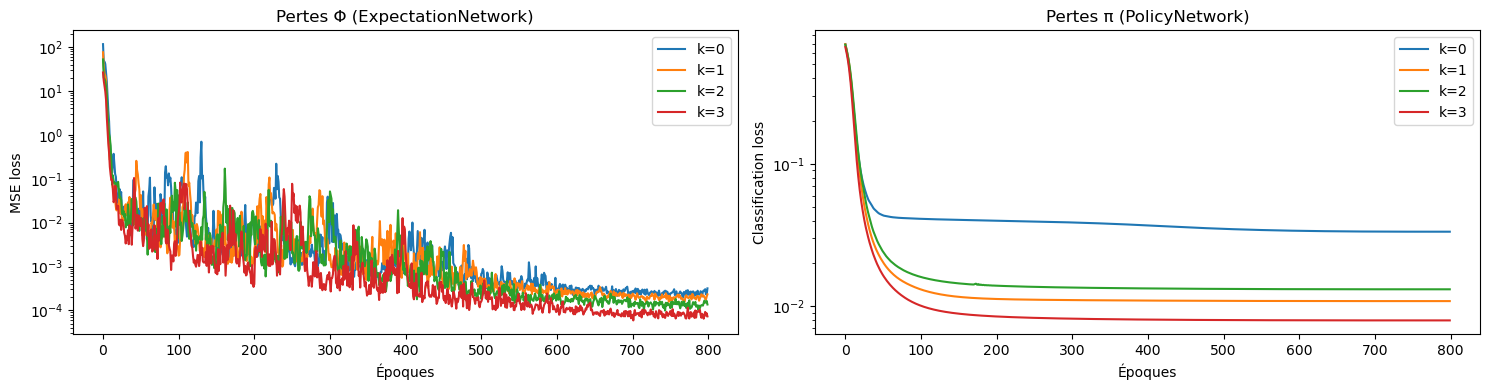

In [ ]:
N = len(phi_losses_all2)

plt.figure(figsize=(15, 4))

# Affichage des pertes Φ
plt.subplot(1, 2, 1)
for k in range(N):
    epochs = list(range(len(phi_losses_all2[k])))
    plt.plot(epochs, phi_losses_all2[k], label=f"k={k}")
plt.title("Pertes Φ (ExpectationNetwork)")
plt.xlabel("Époques")
plt.ylabel("MSE loss")
plt.yscale('log')

plt.legend()

# Affichage des pertes π
plt.subplot(1, 2, 2)
for k in range(N):
    epochs = list(range(len(pi_classif_losses_all2[k])))
    plt.plot(epochs, pi_classif_losses_all2[k], label=f"k={k}")
plt.title("Pertes π (PolicyNetwork)")
plt.xlabel("Époques")
plt.ylabel("Classification loss")
plt.yscale('log')
plt.legend()

plt.tight_layout()
plt.savefig("loss_2D.png")

plt.show()


#### Visualisation des résultats

Les résultats obtenus par réseaux de neurones sont comparés à ceux de la méthode par différences finies :

- Cartes de la fonction valeur $v_0(x, i)$ ;
- Cartes de la politique optimale $\pi_0(x)$ ;
- Éventuellement : erreurs absolues entre les deux méthodes.

Ces visualisations permettent d’évaluer la précision et la robustesse de la méthode neuronale en dimension 2.

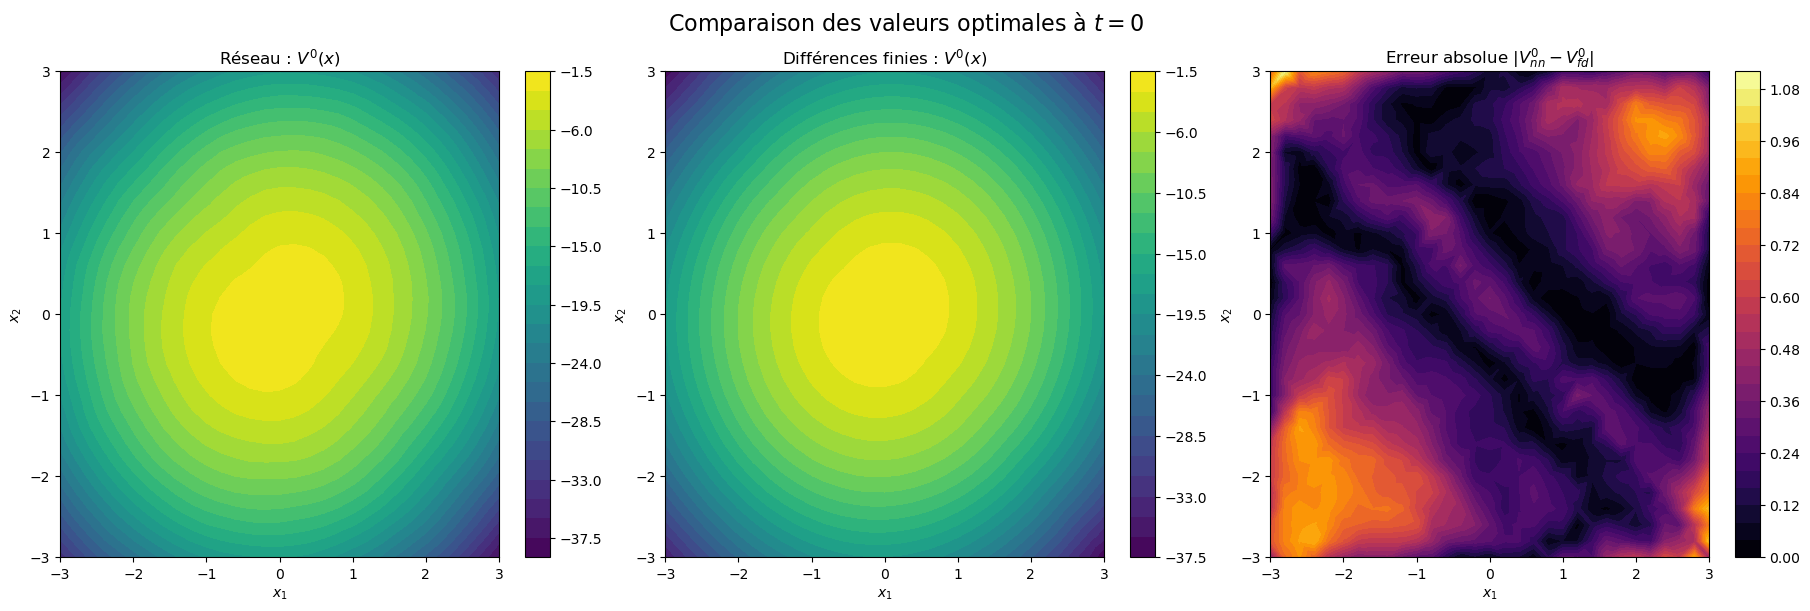

In [ ]:
from matplotlib import cm


# Récupération de la grille et des données
x1_grid = fd_solver.X1
x2_grid = fd_solver.X2
x_grid_2d = fd_solver.x_grid_2d
v_fd = fd_solutions[0][:, 0]  # Valeur FD à t=0, régime 0

# Évaluation par le réseau
grid_tensor = torch.tensor(x_grid_2d, dtype=torch.float32).to(device)
with torch.no_grad():
    v_net = compute_value(phi_list2[0], pi_classif_list2[0], grid_tensor).cpu().numpy().squeeze()

# Calcul de l'erreur absolue
abs_error = np.abs(v_net - v_fd)

# Heatmaps : réseau, FD, erreur
fig, axs = plt.subplots(1, 3, figsize=(18, 6), constrained_layout=True)

# 1. Valeur par le réseau
h1 = axs[0].tricontourf(x1_grid, x2_grid, v_net, levels=30, cmap='viridis')
axs[0].set_title("Réseau : $V^0(x)$")
axs[0].set_xlabel("$x_1$")
axs[0].set_ylabel("$x_2$")
plt.colorbar(h1, ax=axs[0])

# 2. Valeur par différences finies
h2 = axs[1].tricontourf(x1_grid, x2_grid, v_fd, levels=30, cmap='viridis')
axs[1].set_title("Différences finies : $V^0(x)$")
axs[1].set_xlabel("$x_1$")
axs[1].set_ylabel("$x_2$")
plt.colorbar(h2, ax=axs[1])

# 3. Erreur absolue
h3 = axs[2].tricontourf(x1_grid, x2_grid, abs_error, levels=30, cmap='inferno')
axs[2].set_title("Erreur absolue $|V^0_{nn} - V^0_{fd}|$")
axs[2].set_xlabel("$x_1$")
axs[2].set_ylabel("$x_2$")
plt.colorbar(h3, ax=axs[2])
plt.suptitle("Comparaison des valeurs optimales à $t=0$", fontsize=16)
plt.savefig("value_comparison_2D.png")
plt.show()


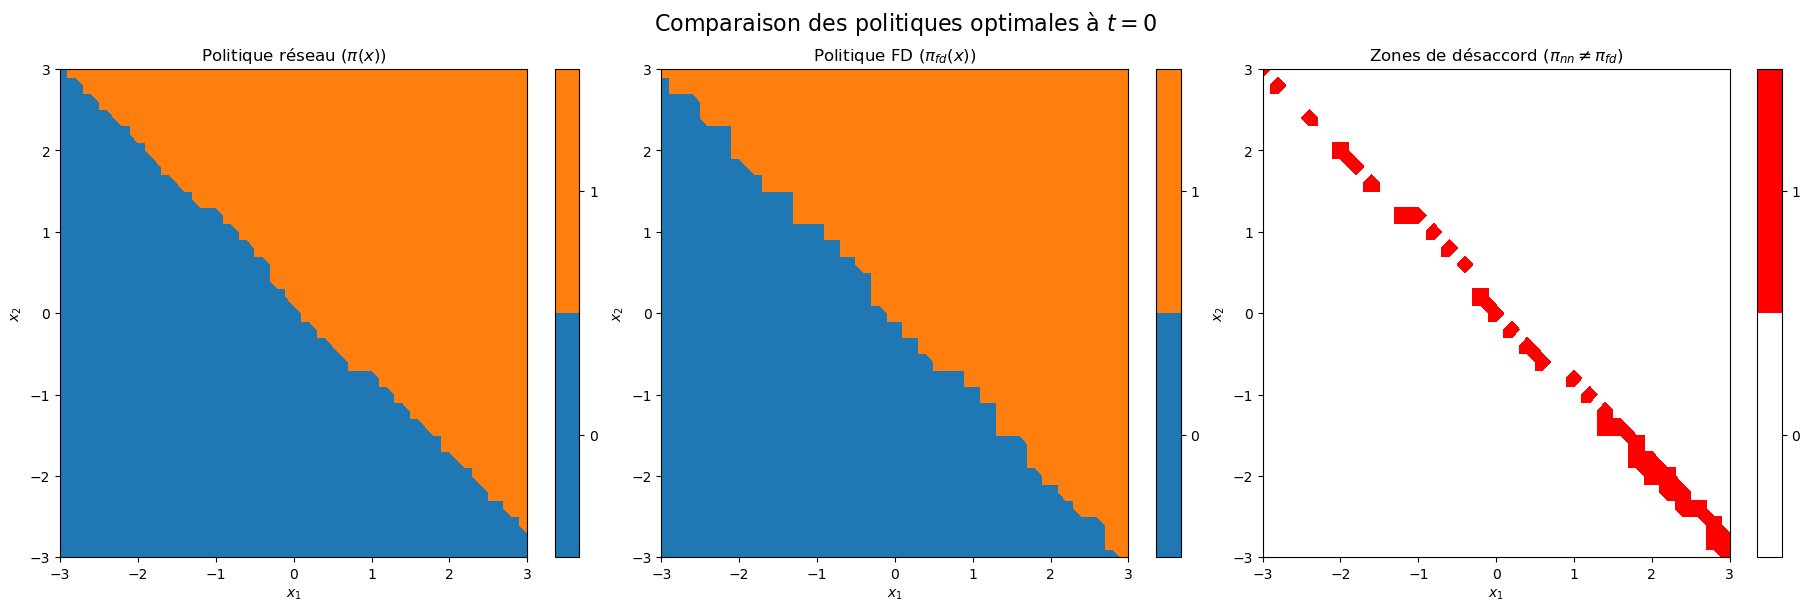

In [ ]:
# 1. Politique optimale par réseau (argmax des logits)
with torch.no_grad():
    logits_nn = pi_classif_list2[0](grid_tensor)  # (n_points, 2)
    policy_nn = torch.argmax(logits_nn, dim=1).cpu().numpy()  # (n_points,)

# 2. Politique optimale par différences finies
policy_fd = np.argmax(fd_solutions[0], axis=1)  # (n_points,)

# 3. Carte de désaccord entre les deux politiques (booléen)
policy_diff = (policy_nn != policy_fd).astype(int)

# Affichage
fig, axs = plt.subplots(1, 3, figsize=(18, 6), constrained_layout=True)

# 1. Policy NN
h1 = axs[0].tricontourf(x1_grid, x2_grid, policy_nn, levels=[-0.5, 0.5, 1.5], colors=["#1f77b4", "#ff7f0e"])
axs[0].set_title(r"Politique réseau ($\pi(x)$)")
axs[0].set_xlabel("$x_1$")
axs[0].set_ylabel("$x_2$")
plt.colorbar(h1, ax=axs[0], ticks=[0, 1])

# 2. Policy FD
h2 = axs[1].tricontourf(x1_grid, x2_grid, policy_fd, levels=[-0.5, 0.5, 1.5], colors=["#1f77b4", "#ff7f0e"])
axs[1].set_title(r"Politique FD ($\pi_{fd}(x)$)")
axs[1].set_xlabel("$x_1$")
axs[1].set_ylabel("$x_2$")
plt.colorbar(h2, ax=axs[1], ticks=[0, 1])

# 3. Carte des désaccords
h3 = axs[2].tricontourf(x1_grid, x2_grid, policy_diff, levels=[-0.5, 0.5, 1.5], colors=["white", "red"])
axs[2].set_title(r"Zones de désaccord ($\pi_{nn} \neq \pi_{fd}$)")
axs[2].set_xlabel("$x_1$")
axs[2].set_ylabel("$x_2$")
plt.colorbar(h3, ax=axs[2], ticks=[0, 1])

plt.suptitle("Comparaison des politiques optimales à $t=0$", fontsize=16)
plt.savefig("policy_comparison_2D.png")
plt.show()
